### Further clean DELINQUENCY variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, print_percentile, describe_all
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

36

In [6]:
START = time.time()

### Setup

In [8]:
%%time
train = read_file(f"../{RAW_DATA_PATH}/train_parquet_rounded/delinquency2.parquet")
test = read_file(f"../{RAW_DATA_PATH}/test_parquet_rounded/delinquency2.parquet")

Shape of data: (5531451, 49)
Shape of data: (11363762, 48)
CPU times: user 15.5 s, sys: 9.95 s, total: 25.5 s
Wall time: 5.4 s


In [9]:
%%time
labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 426 ms, sys: 29.7 ms, total: 456 ms
Wall time: 455 ms


In [10]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 6.25 s, sys: 912 ms, total: 7.17 s
Wall time: 7.12 s


In [11]:
del test

In [12]:
train.shape, public_test.shape, private_test.shape

((5531451, 49), (5719469, 48), (5644293, 48))

In [13]:
df_list = [train, public_test, private_test]

In [14]:
d_variables = get_cols(train, ["D_"])

In [15]:
print(sorted(d_variables))

['D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'D_108', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_127', 'D_128', 'D_129', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']


In [16]:
train["target"].mean()

0.24909720794778803

In [17]:
# for df in df_list:
#     insert_row_number(df)

In [18]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [19]:
# train_corr = train.loc[:, train.columns[4:-1]].corr()
# train_corr.to_csv(f"../{RAW_DATA_PATH}/pre_clean_train_delinquency1_corr.csv", index=False)

In [20]:
# train_corr = read_file(f"../{RAW_DATA_PATH}/pre_clean_train_delinquency1_corr.csv")
# train_corr.index = train_corr.columns

### Rounding

#### Round to 2 decimals

In [21]:
# %%time
# # Skip some columns
# col_to_round = list(set(d_variables) - set())
# d_variables_psi_list = []
# for col in tqdm(col_to_round):
#     try:
#         pre_round = check_psi(df_list, col)[1]
#         df_list = round_dfs(df_list, col, decimals=2, add_new_col=False, nb_workers=8)
#         post_round = check_psi(df_list, col)[1]
#         d_variables_psi_list.append((col, pre_round, post_round))
#     except:
#         print(f"Skip column {col}")

In [22]:
# d_psi_df = pd.DataFrame(d_variables_psi_list, columns=["feature", "psi_before", "psi_after"])
# sorted(d_psi_df.loc[d_psi_df["psi_before"] < d_psi_df["psi_after"], "feature"].tolist())

In [23]:
# %%time
# train = df_list[0]
# test = pd.concat(df_list[1:], axis=0)
# test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)
# train.to_parquet(f"../{RAW_DATA_PATH}/train_parquet_rounded/delinquency2.parquet")
# test.to_parquet(f"../{RAW_DATA_PATH}/test_parquet_rounded/delinquency2.parquet")

### D_103, D_108, D_116 => D_183

In [24]:
for df in df_list:
    df["D_103"] = df["D_103"].fillna(1)
    df["D_103"] = df["D_103"].replace((0, 1), (-0.5, 0.5))
    df = clip_col(df, "D_108", top_value=2, add_new_col=False)
    df["D_183"] = df["D_108"] + df["D_103"] + df["D_116"] + 0.5

5503205 null count, 0.995 null proportion
0.2482 of the targets have label = 1


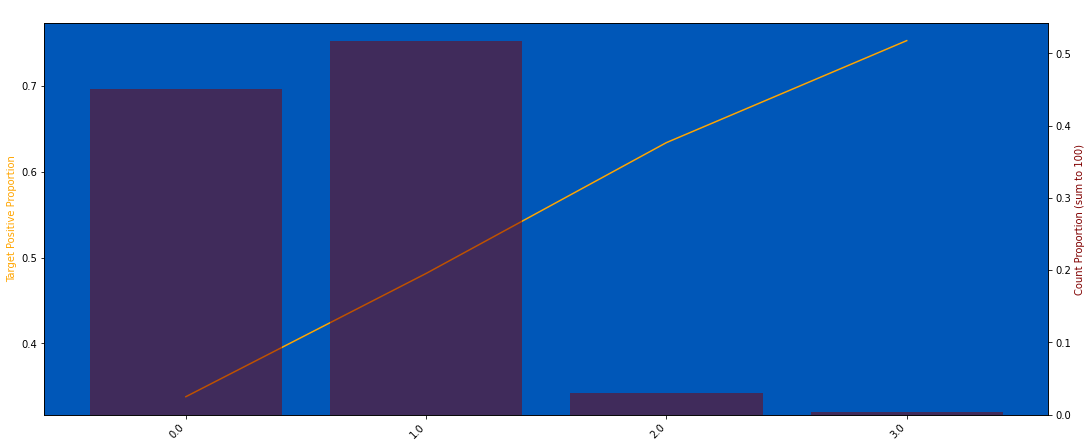

In [25]:
plot_target_check(train, "D_183", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

In [26]:
col_to_drop = ["D_103", "D_108", "D_116", "D_127"]

In [27]:
for df in tqdm(df_list):
    df.drop(columns=col_to_drop, errors="ignore", inplace=True)

100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


### D_135, D_137, D_138, D_140 => D_1314

In [28]:
for df in df_list:
    df["D_138"] = (df["D_138"] * 2).round(0)
    df = clip_col(df, "D_138", top_value=2, add_new_col=False)
    df["D_138"] = df["D_138"].replace(0, 1).fillna(0)

In [29]:
for df in df_list:
    df["D_140"] = df["D_140"].fillna(0.5)
    df["D_135"] = (df["D_135"] + 1).fillna(0)
    df["D_137"] = (df["D_137"] + 1).fillna(0)
    df["D_1314"] = df["D_135"] + df["D_137"] + df["D_138"] + df["D_140"]
    df = clip_col(df, "D_1314", top_value=4, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


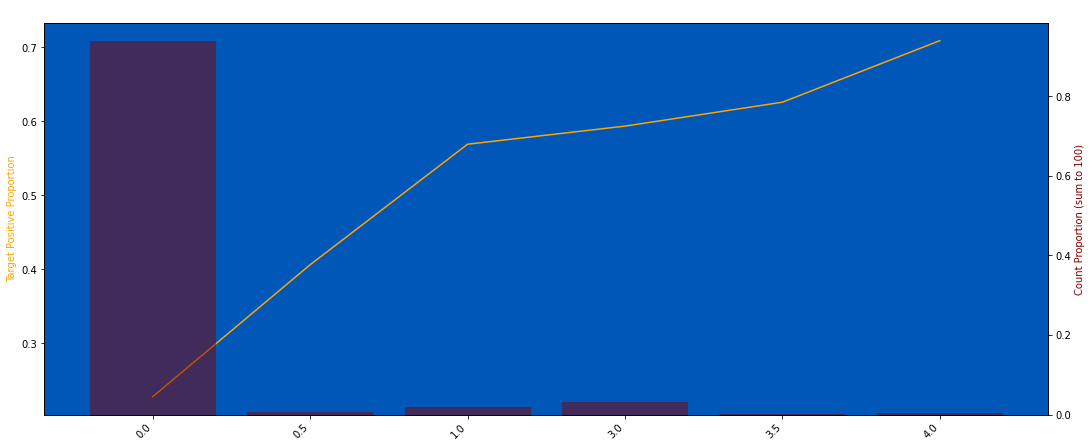

In [30]:
plot_target_check(train, "D_1314", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

In [31]:
for df in df_list:
    df.drop(columns=["D_135", "D_137", "D_138", "D_140"], errors="ignore", inplace=True)

### D_139, D_143 => D_1343

In [32]:
for df in df_list:
    df["D_139"] = df["D_139"].fillna(1)
    df["D_143"] = df["D_143"].fillna(1)
    df["D_1343"] = df["D_139"] + df["D_143"]

0 null count, 0.000 null proportion
nan of the targets have label = 1


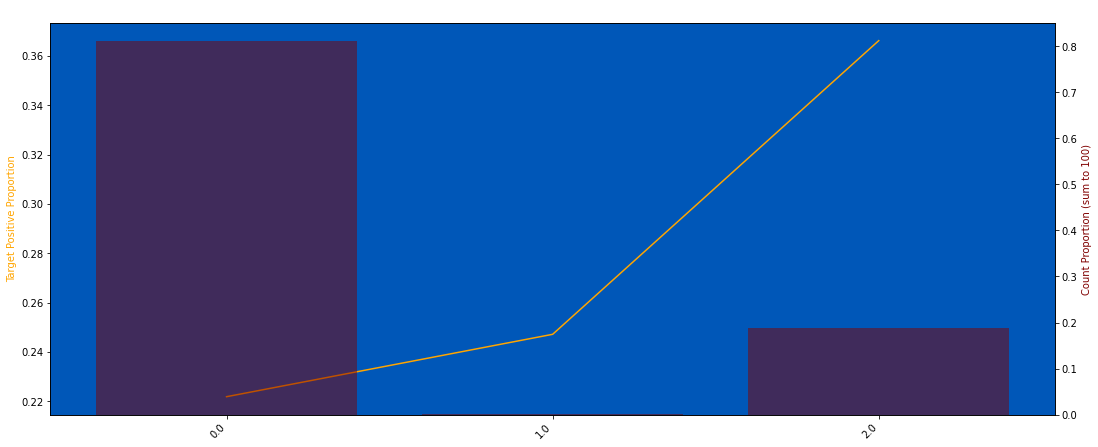

In [33]:
plot_target_check(train, "D_1343", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

In [34]:
for df in df_list:
    df.drop(columns=["D_143", "D_139"], errors="ignore", inplace=True)

### Drop Columns

In [35]:
for df in df_list:
    df.drop(columns="D_121", errors="ignore", inplace=True)

### D_102 @Continuous, Decreasing

In [36]:
# plot_target_check(train, "D_102", q=50, use_raw_bin=True)

In [37]:
for df in df_list:
    df["D_102"] = df["D_102"].fillna(0.02)
    df["D_102"] = df["D_102"].replace((0, 1.08), np.nan)

3106313 null count, 0.562 null proportion
0.2063 of the targets have label = 1


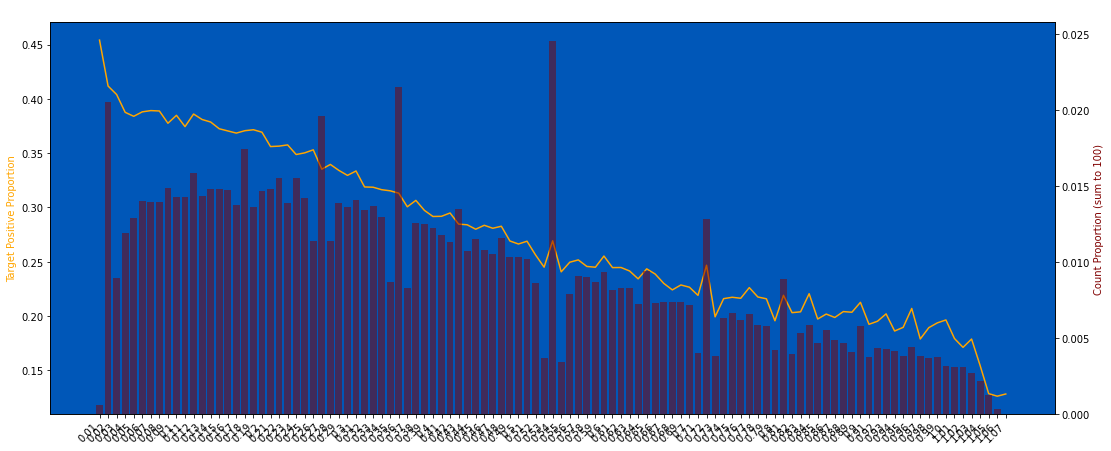

In [38]:
plot_target_check(train, "D_102", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

In [39]:
# plot_train_test_distribution(df_list, "D_102", nunique_thr=3000, without_drop_tail=True)

### D_104 @Continuous, Decreasing

In [40]:
# plot_target_check(train, "D_104", q=50, use_raw_bin=True)

In [41]:
describe_all(df_list, "D_104")

,train,public test,private test
count,"5,429,903.0000","5,666,462.0000","5,599,600.0000"
mean,0.4456,0.4541,0.4530
std,0.4807,0.4816,0.4817
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.9600,0.9600,0.9600
max,1.3000,1.3300,1.2300
null_proportion,0.0184,0.0093,0.0079


In [42]:
print_percentile(df_list, "D_104", 99.9)

99.9th percentile:
train : 1.01
public test : 1.01
private test : 1.01


In [43]:
for df in df_list:
    df = clip_col(df, "D_104", top_value=1.01, add_new_col=False)
    df["D_104"] = df["D_104"].fillna(0.93).replace(0, np.nan)

2919859 null count, 0.528 null proportion
0.1973 of the targets have label = 1


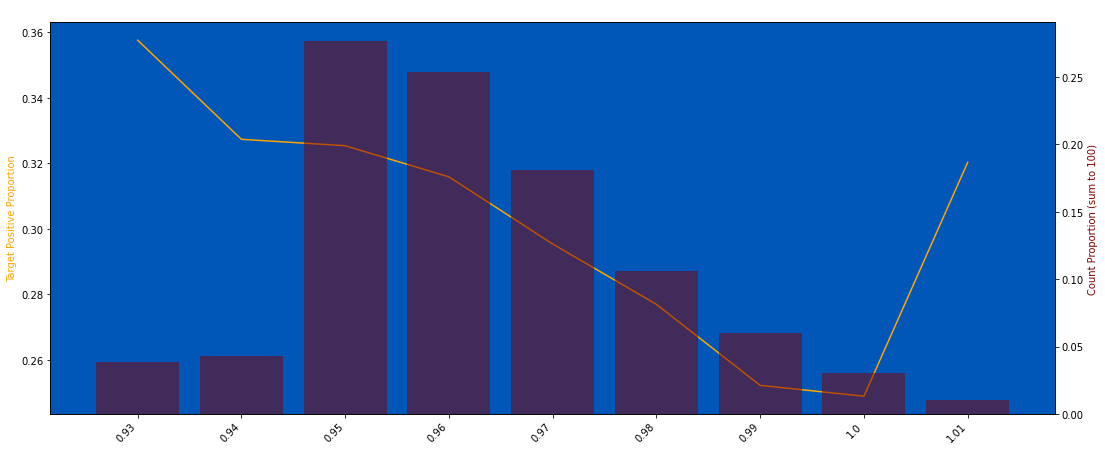

In [44]:
plot_target_check(train, "D_104", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True, without_drop_tail=True)

In [45]:
# plot_train_test_distribution(df_list, "D_104", nunique_thr=3000, without_drop_tail=True)

### D_105 @Continuous, -

In [46]:
# plot_target_check(train, "D_105", q=50, use_raw_bin=True)

In [47]:
describe_all(df_list, "D_105")

,train,public test,private test
count,"2,510,020.0000","2,666,886.0000","2,628,675.0000"
mean,0.3651,0.3779,0.3833
std,0.2505,0.2530,0.2545
min,-0.0300,-0.0300,-0.0300
25%,0.1700,0.1800,0.1800
50%,0.3300,0.3400,0.3500
75%,0.5200,0.5400,0.5500
max,5.6300,6.0800,4.4700
null_proportion,0.5462,0.5337,0.5343


In [48]:
print_percentile(df_list, "D_105", 99.8)

99.8th percentile:
train : 1.18
public test : 1.16
private test : 1.16


In [49]:
for df in df_list:
    df = clip_col(df, "D_105", top_value=1.15, add_new_col=False)

3021431 null count, 0.546 null proportion
0.2027 of the targets have label = 1


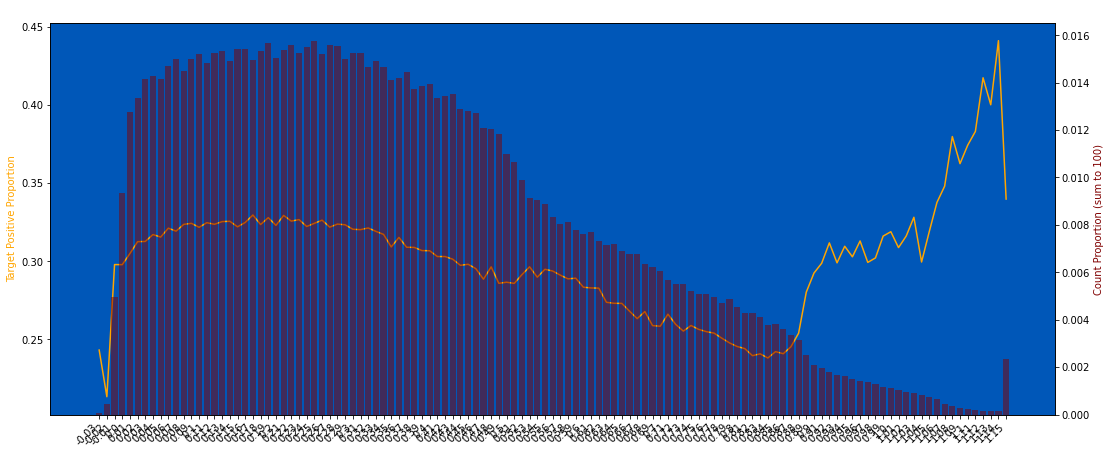

In [50]:
plot_target_check(train, "D_105", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

In [51]:
# plot_train_test_distribution(df_list, "D_105", nunique_thr=3000)

### D_106 (Check Stack)

In [52]:
# plot_target_check(train, "D_106", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [53]:
for df in df_list:
    df["D_106"] = ((df["D_106"] + 0.001) / 0.0434).round(0)

In [54]:
describe_all(df_list, "D_106")

,train,public test,private test
count,"541,349.0000","671,217.0000","681,455.0000"
mean,4.6061,4.7939,4.8699
std,28.9752,16.1251,17.3984
min,0.0000,0.0000,0.0000
25%,1.0000,2.0000,2.0000
50%,3.0000,3.0000,3.0000
75%,6.0000,6.0000,6.0000
max,"14,443.0000","7,013.0000","9,054.0000"
null_proportion,0.9021,0.8826,0.8793


In [55]:
for df in df_list:
    df["D_106"] = df["D_106"].parallel_apply(lambda x: manual_stack(x, start=19, stack_interval=2, denom=1))
    df["D_106"] = df["D_106"].parallel_apply(lambda x: manual_stack(x, start=17, stack_interval=2, denom=1))
    df["D_106"] = df["D_106"].parallel_apply(lambda x: manual_stack(x, start=21, stack_interval=3, denom=1))

In [56]:
print_percentile(df_list, "D_106", 99.9)

99.9th percentile:
train : 27.0
public test : 26.0
private test : 26.0


In [57]:
for df in df_list:
    df = clip_col(df, "D_106", top_value=25, add_new_col=False)

4990102 null count, 0.902 null proportion
0.2164 of the targets have label = 1


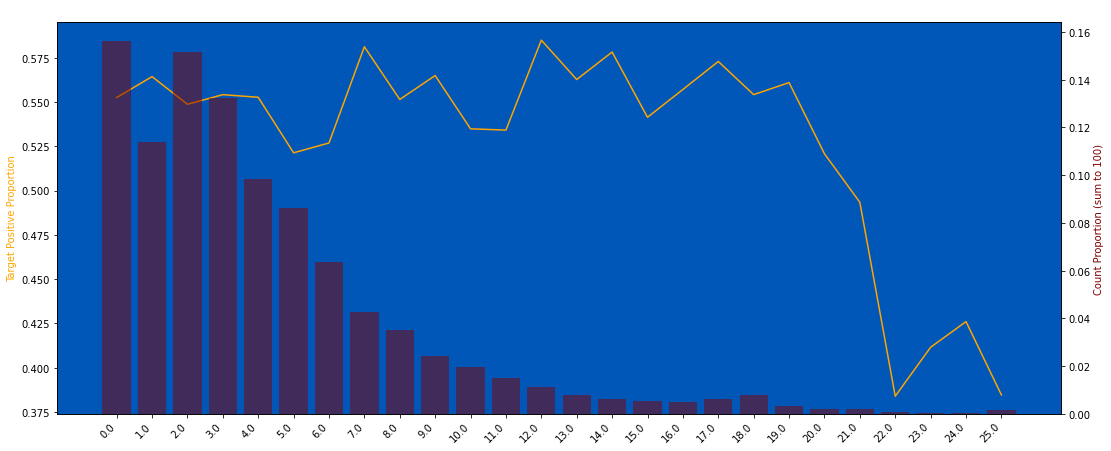

In [58]:
plot_target_check(train, "D_106", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [59]:
# plot_train_test_distribution(df_list, "D_106", nunique_thr=3000, without_drop_tail=True)

### D_107 (Done Integer)

In [60]:
# plot_target_check(train, "D_107", q=50, use_raw_bin=True)

In [61]:
%%time
df_list = round_dfs(df_list, col="D_107", decimals=2, add_new_col=False)

CPU times: user 1.01 s, sys: 2.45 s, total: 3.46 s
Wall time: 4.53 s


In [62]:
for df in df_list:
    df["D_107"] = ((df["D_107"] + 0.001) / 0.33).round(0)

In [63]:
describe_all(df_list, "D_107")

,train,public test,private test
count,"5,429,903.0000","5,666,462.0000","5,599,600.0000"
mean,0.6057,0.6193,0.6179
std,0.7717,0.7778,0.7764
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,1.0000,1.0000,1.0000
max,21.0000,21.0000,15.0000
null_proportion,0.0184,0.0093,0.0079


In [64]:
print_percentile(df_list, "D_107", 99.9)

99.9th percentile:
train : 4.0
public test : 4.0
private test : 4.0


In [65]:
for df in df_list:
    df = clip_col(df, "D_107", top_value=4, add_new_col=False)

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1


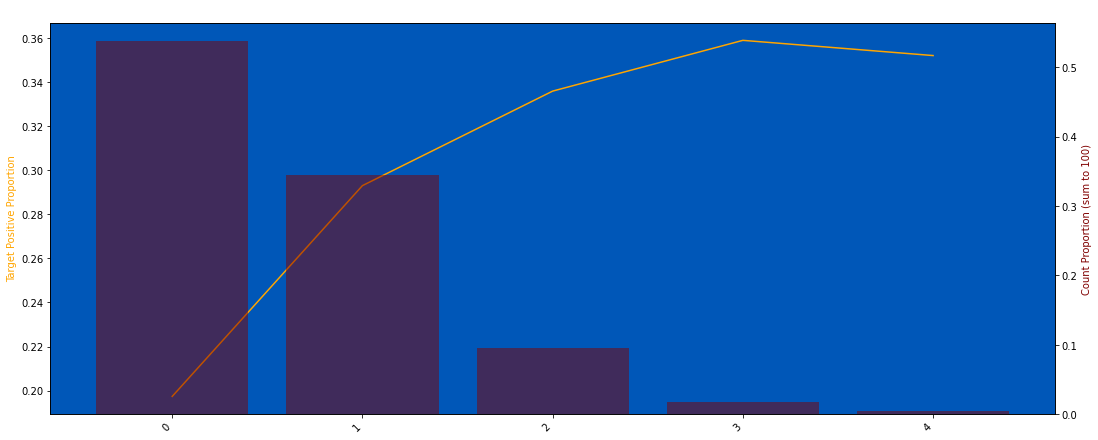

In [66]:
plot_target_check(train, "D_107", q=50, use_raw_bin=True, without_drop_tail=True)

In [67]:
# plot_train_test_distribution(df_list, "D_107", nunique_thr=3000, without_drop_tail=True)

### D_109 (Done Binary)

In [68]:
# plot_target_check(train, "D_109", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [69]:
%%time
df_list = round_dfs(df_list, col="D_109", decimals=2, add_new_col=False)

CPU times: user 983 ms, sys: 2.51 s, total: 3.49 s
Wall time: 4.47 s


1597 null count, 0.000 null proportion
0.2298 of the targets have label = 1


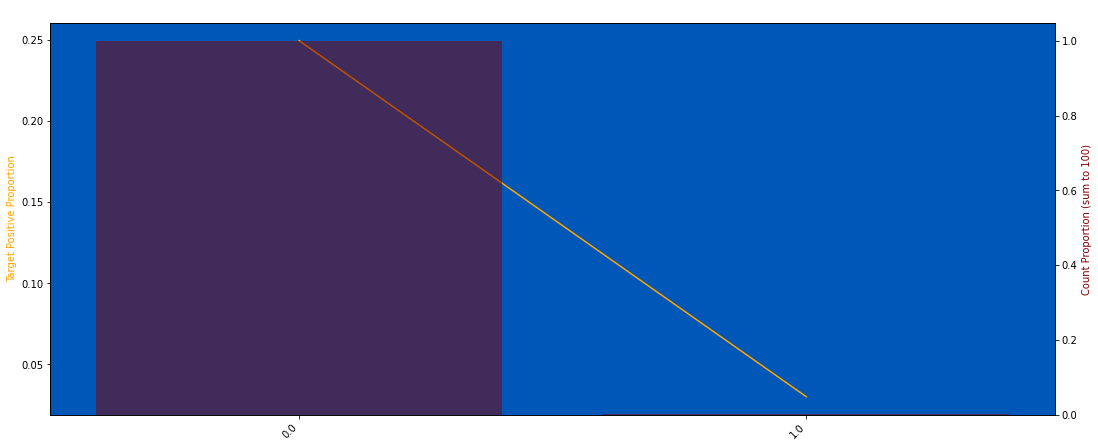

In [70]:
plot_target_check(train, "D_109", q=50, use_raw_bin=True, nunique_thr=10, strfy_x=True)

In [71]:
# plot_train_test_distribution(df_list, "D_109", nunique_thr=10, without_drop_tail=True)

### D_110 (Done Integer)

In [72]:
# plot_target_check(train, "D_110", q=50, use_raw_bin=True)

In [73]:
%%time
df_list = round_dfs(df_list, col="D_110", decimals=2, add_new_col=False)

CPU times: user 958 ms, sys: 2.48 s, total: 3.43 s
Wall time: 4.9 s


In [74]:
for df in df_list:
    df["D_110"] = (df["D_110"] / 0.2).round(0)

5500117 null count, 0.994 null proportion
0.2473 of the targets have label = 1


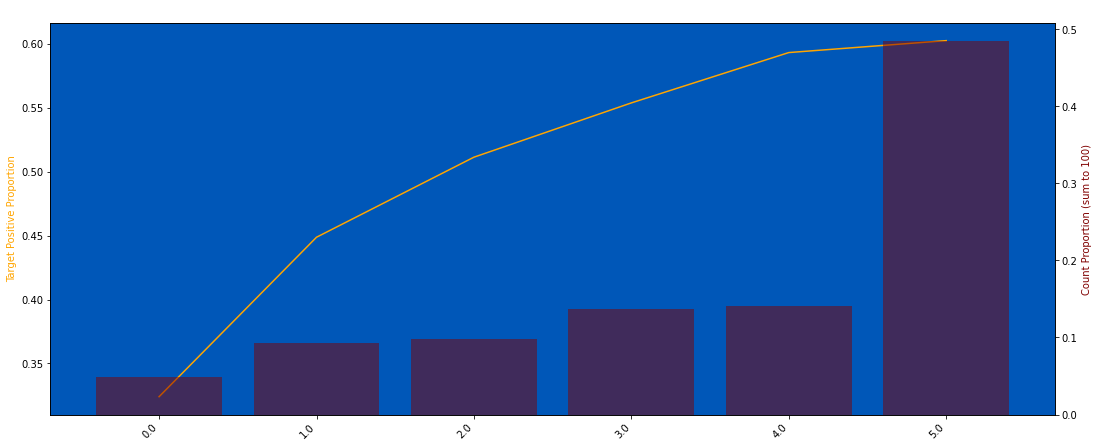

In [75]:
plot_target_check(train, "D_110", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [76]:
# plot_train_test_distribution(df_list, "D_110", nunique_thr=3000, without_drop_tail=True)

### D_111 @Integer, Increasing

In [77]:
# plot_target_check(train, "D_111", q=50, use_raw_bin=True)

In [78]:
%%time
df_list = round_dfs(df_list, col="D_111", decimals=2, add_new_col=False)

CPU times: user 1.02 s, sys: 2.36 s, total: 3.38 s
Wall time: 4.86 s


In [79]:
for df in df_list:
    df["D_111"] = (df["D_111"] * 2).round(0)
    df = clip_col(df, "D_111", top_value=2, add_new_col=False)

5500117 null count, 0.994 null proportion
0.2473 of the targets have label = 1


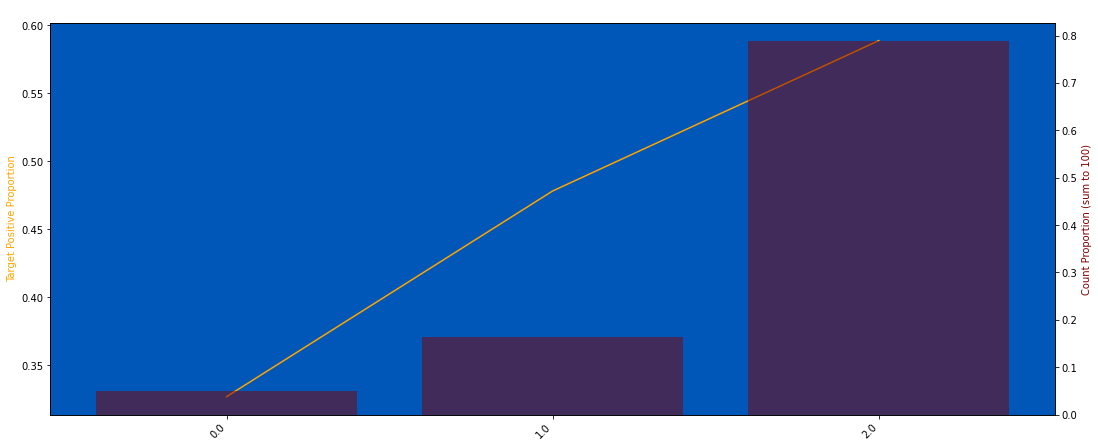

In [80]:
plot_target_check(train, "D_111", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [81]:
# plot_train_test_distribution(df_list, "D_111", nunique_thr=3000, without_drop_tail=True)

### D_112 (Done Integer)

In [82]:
# plot_target_check(train, "D_112", q=50, use_raw_bin=True, nunique_thr=1000)

In [83]:
%%time
df_list = round_dfs(df_list, col="D_112", decimals=2, add_new_col=False)

CPU times: user 957 ms, sys: 2.46 s, total: 3.42 s
Wall time: 4.48 s


In [84]:
for df in df_list:
    df["D_112"] = df["D_112"].map({0: 0, 0.01: 1, 0.02: 2, 1: 3})

2650 null count, 0.000 null proportion
0.3026 of the targets have label = 1


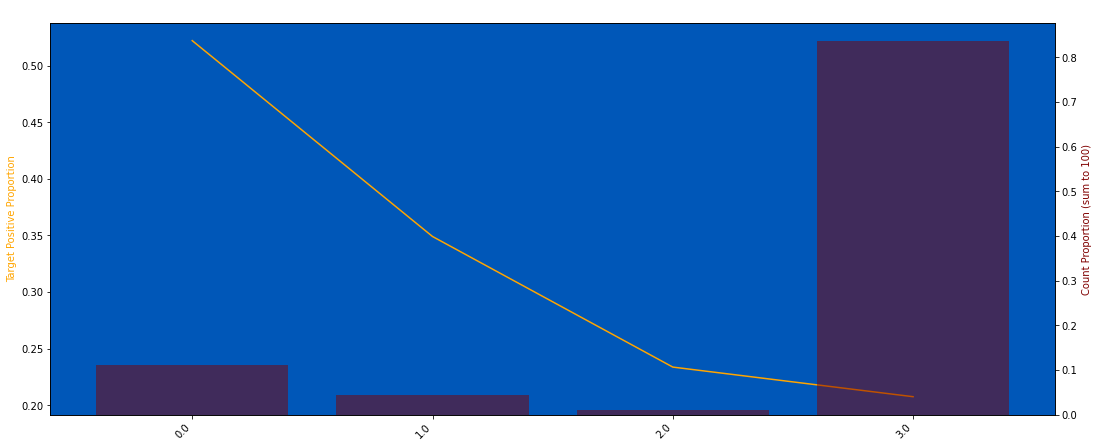

In [85]:
plot_target_check(train, "D_112", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [86]:
# plot_train_test_distribution(df_list, "D_112", nunique_thr=3000, without_drop_tail=True)

### D_113 (Done Integer)

In [87]:
# plot_target_check(train, "D_113", q=50, use_raw_bin=True, nunique_thr=50)

In [88]:
for df in df_list:
    df["D_113"] = (df["D_113"] * 2).round(0)

In [89]:
describe_all(df_list, "D_113")

,train,public test,private test
count,"5,354,735.0000","5,565,356.0000","5,514,165.0000"
mean,0.2334,0.2377,0.2494
std,0.5022,0.5050,0.5184
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,50.0000,23.0000,32.0000
null_proportion,0.0319,0.0269,0.0231


In [90]:
print_percentile(df_list, "D_113", 99.8)

99.8th percentile:
train : 2.0
public test : 2.0
private test : 2.0


In [91]:
for df in df_list:
    df = clip_col(df, "D_113", top_value=2, add_new_col=False)
    df["D_113"] = df["D_113"].fillna(3)

0 null count, 0.000 null proportion
nan of the targets have label = 1


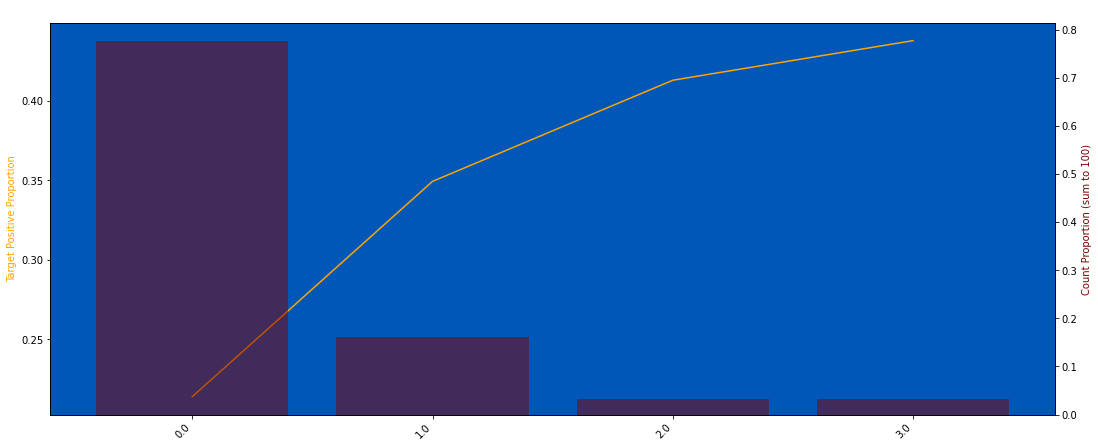

In [92]:
plot_target_check(train, "D_113", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [93]:
# plot_train_test_distribution(df_list, "D_113", nunique_thr=3000, without_drop_tail=True)

### D_114 @Category

In [94]:
for df in df_list:
    df["D_114"] = df["D_114"].fillna(0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


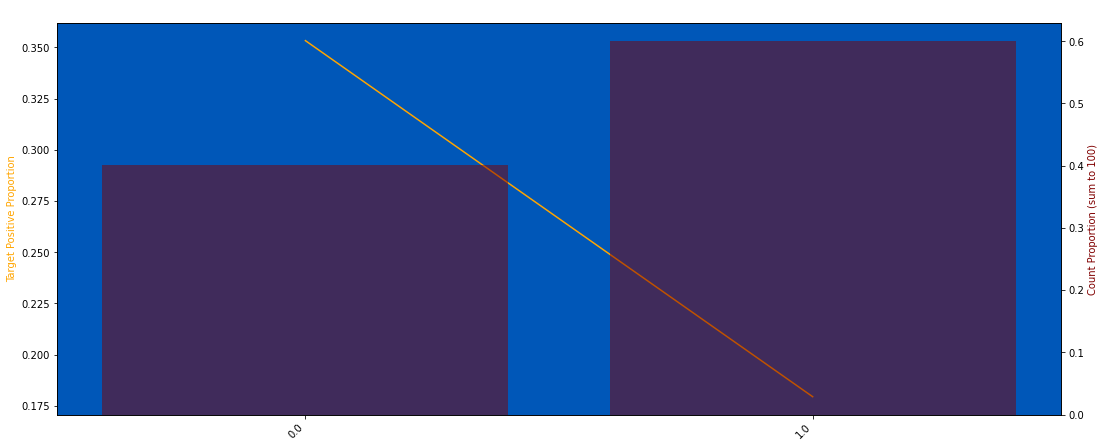

In [95]:
plot_target_check(train, "D_114", q=50, use_raw_bin=True, without_drop_tail=True, strfy_x=True)

In [96]:
# plot_train_test_distribution(df_list, "D_114", nunique_thr=3000)

### D_115 @Continuous, Decreasing

In [97]:
# plot_target_check(train, "D_115", q=50, use_raw_bin=True)

In [98]:
describe_all(df_list, "D_115")

,train,public test,private test
count,"5,354,735.0000","5,565,356.0000","5,514,165.0000"
mean,0.2731,0.2733,0.2741
std,0.2562,0.2607,0.2628
min,0.0000,0.0000,0.0000
25%,0.0600,0.0600,0.0600
50%,0.1900,0.1800,0.1800
75%,0.4300,0.4300,0.4300
max,1.9900,1.9900,1.9900
null_proportion,0.0319,0.0269,0.0231


In [99]:
print_percentile(df_list, "D_115", 99.9)

99.9th percentile:
train : 1.32
public test : 1.34
private test : 1.34


In [100]:
for df in df_list:
    df = clip_col(df, "D_115", top_value=1.35, add_new_col=False)

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1


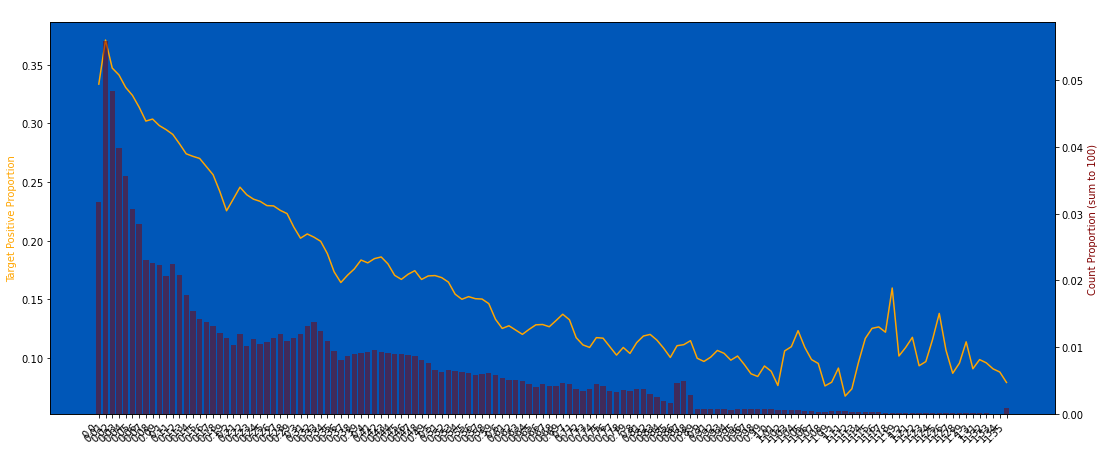

In [101]:
plot_target_check(train, "D_115", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [102]:
# plot_train_test_distribution(df_list, "D_115", nunique_thr=500)

### D_117 @Category

In [103]:
for df in df_list:
    df["D_117"] = df["D_117"].fillna(1)
    df["D_117"] = df["D_117"].replace(-1, np.nan)

1456084 null count, 0.263 null proportion
0.2733 of the targets have label = 1


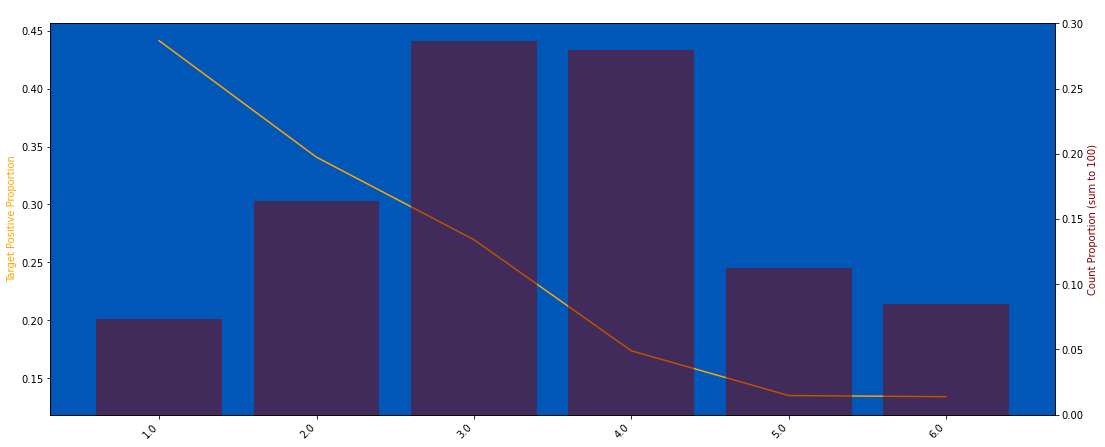

In [104]:
plot_target_check(train, "D_117", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [105]:
# plot_train_test_distribution(df_list, "D_117", nunique_thr=20)

### D_118 @Continuous, Decreasing

In [106]:
# plot_target_check(train, "D_118", q=50, use_raw_bin=True)

In [107]:
describe_all(df_list, "D_118")

,train,public test,private test
count,"5,354,735.0000","5,565,356.0000","5,514,165.0000"
mean,0.2785,0.2827,0.2860
std,0.2560,0.2593,0.2616
min,0.0000,0.0000,0.0000
25%,0.0600,0.0600,0.0600
50%,0.2200,0.2100,0.2100
75%,0.4400,0.4400,0.4500
max,1.9700,1.9700,1.9700
null_proportion,0.0319,0.0269,0.0231


In [108]:
print_percentile(df_list, "D_118", 99.9)

99.9th percentile:
train : 1.32
public test : 1.35
private test : 1.34


In [109]:
for df in df_list:
    df["D_118"] = df["D_118"].replace(0, np.nan)
    df = clip_col(df, "D_118", top_value=1.35, add_new_col=False)

560952 null count, 0.101 null proportion
0.3349 of the targets have label = 1


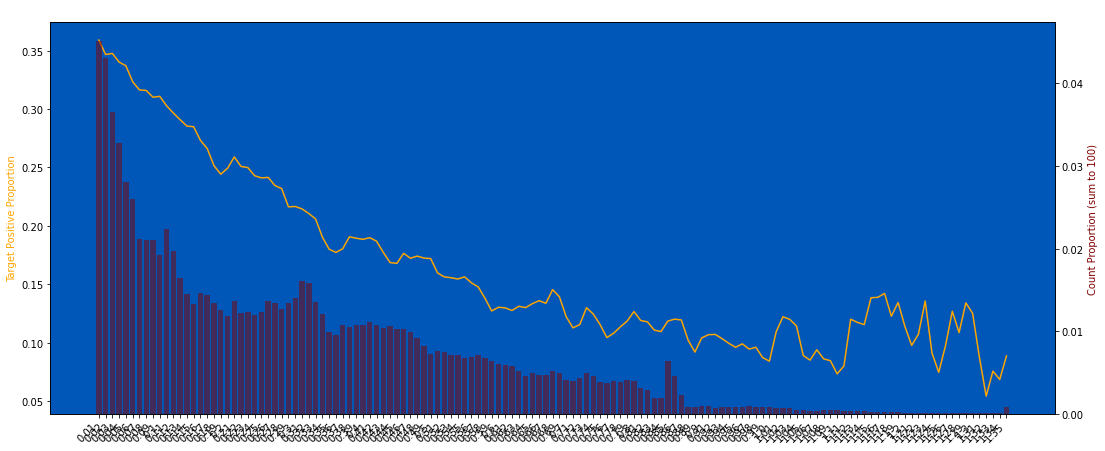

In [110]:
plot_target_check(train, "D_118", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

In [111]:
# plot_train_test_distribution(df_list, "D_118", nunique_thr=500)

### D_119 @Continuous, Decreasing

In [112]:
# plot_target_check(train, "D_119", q=50, use_raw_bin=True)

In [113]:
for df in df_list:
    df["D_119"] = df["D_119"].fillna(0.01)
    df["D_119"] = df["D_119"].replace(0, np.nan)

In [114]:
print_percentile(df_list, "D_119", 99.9)

99.9th percentile:
train : 1.33
public test : 1.35
private test : 1.35


In [115]:
for df in df_list:
    df = clip_col(df, "D_119", top_value=1.35, add_new_col=False)

423108 null count, 0.076 null proportion
0.2905 of the targets have label = 1


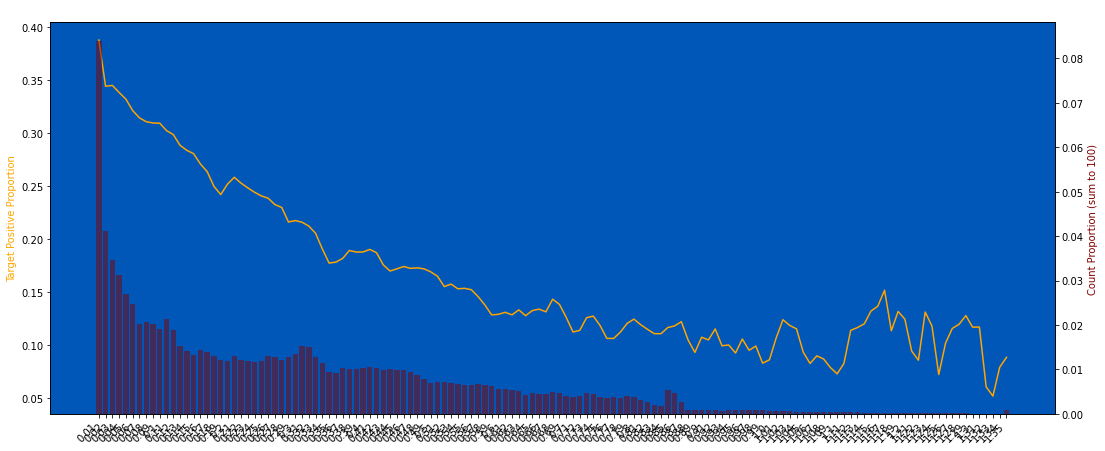

In [116]:
plot_target_check(train, "D_119", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

In [117]:
# plot_train_test_distribution(df_list, "D_119", nunique_thr=500)

### D_120 @Category

In [118]:
for df in df_list:
    df["D_120"] = df["D_120"].fillna(1)

0 null count, 0.000 null proportion
nan of the targets have label = 1


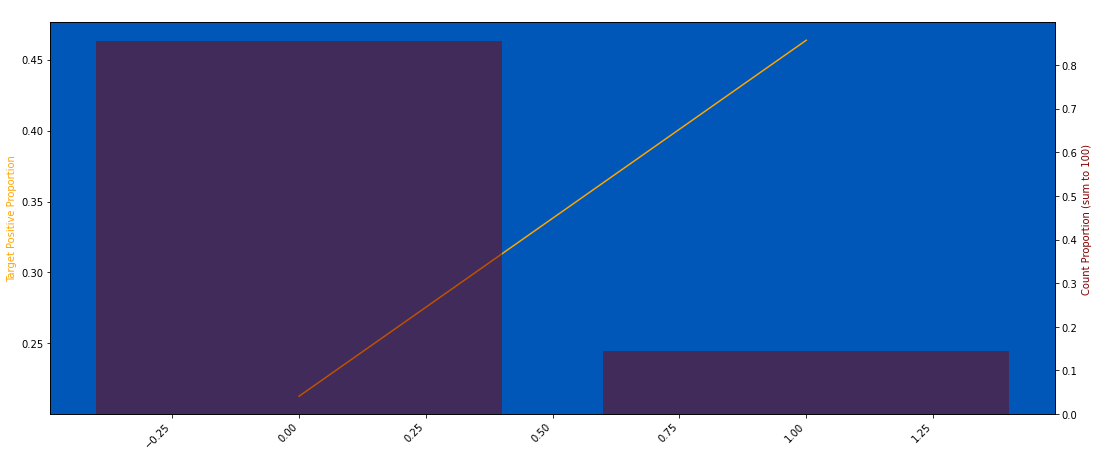

In [119]:
plot_target_check(train, "D_120", q=50, use_raw_bin=True, nunique_thr=500, without_drop_tail=True)

In [120]:
# plot_train_test_distribution(df_list, "D_120", nunique_thr=500)

### D_122 @Integer, Decreasing

In [121]:
# plot_target_check(train, "D_122", q=50, use_raw_bin=True, nunique_thr=100)

In [122]:
for df in df_list:
    df["D_122"] = ((df["D_122"] + 0.001) / 0.14).round(0)

In [123]:
for df in df_list:
    df["D_122"] = df["D_122"].fillna(1)
    df["D_122"] = df["D_122"].replace(0, np.nan)

In [124]:
describe_all(df_list, "D_122")

,train,public test,private test
count,"5,473,202.0000","5,673,735.0000","5,600,568.0000"
mean,2.7677,2.6921,2.6526
std,1.6463,1.6312,1.6161
min,1.0000,1.0000,1.0000
25%,1.0000,1.0000,1.0000
50%,3.0000,2.0000,2.0000
75%,4.0000,4.0000,4.0000
max,14.0000,14.0000,13.0000
null_proportion,0.0105,0.0080,0.0077


In [125]:
print_percentile(df_list, "D_122", 99.9)

99.9th percentile:
train : 9.0
public test : 9.0
private test : 9.0


In [126]:
for df in df_list:
    df = clip_col(df, "D_122", top_value=9, add_new_col=False)

58249 null count, 0.011 null proportion
0.2432 of the targets have label = 1


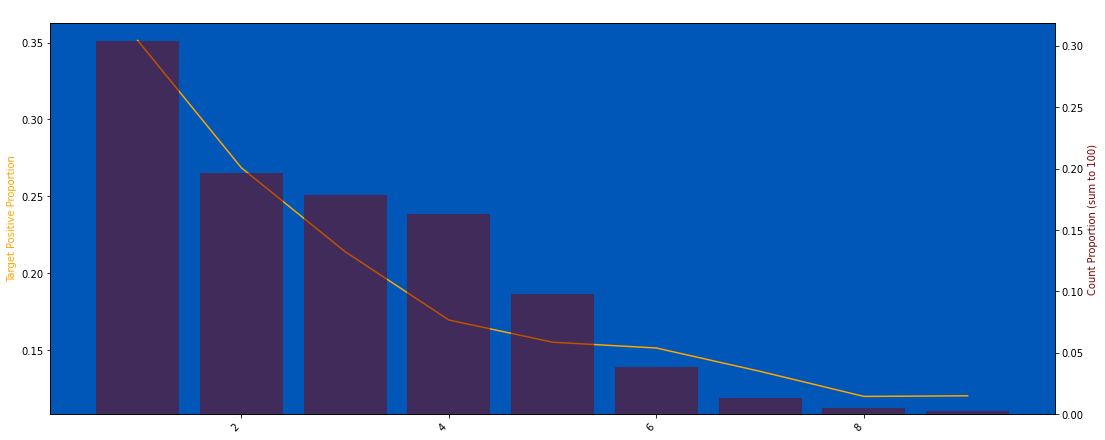

In [127]:
plot_target_check(train, "D_122", q=50, use_raw_bin=True, without_drop_tail=True)

In [128]:
# plot_train_test_distribution(df_list, "D_122", nunique_thr=500, without_drop_tail=True)

### D_123 @Binary, Increasing

In [129]:
# plot_target_check(train, "D_123", q=50, use_raw_bin=True, nunique_thr=50)

In [130]:
describe_all(df_list, "D_123")

,train,public test,private test
count,"5,354,735.0000","5,565,356.0000","5,514,165.0000"
mean,0.0455,0.0508,0.0483
std,0.2456,0.4246,0.2403
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,104.0000,255.0000,74.0000
null_proportion,0.0319,0.0269,0.0231


In [131]:
print_percentile(df_list, "D_123", 99.9)

99.9th percentile:
train : 1.0
public test : 1.0
private test : 1.0


In [132]:
for df in df_list:
    df = clip_col(df, "D_123", top_value=1, add_new_col=False)

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1


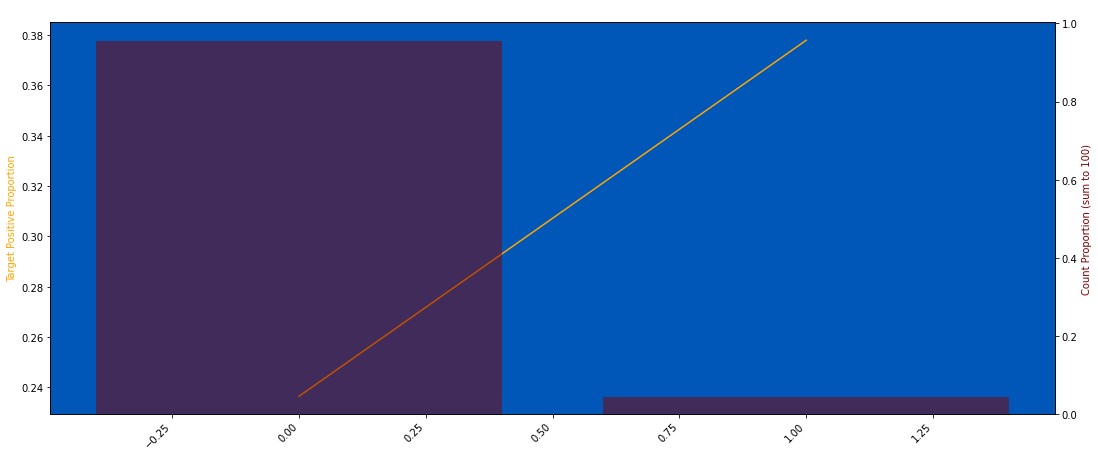

In [133]:
plot_target_check(train, "D_123", q=50, use_raw_bin=True, nunique_thr=50)

In [134]:
# plot_train_test_distribution(df_list, "D_123", nunique_thr=500, without_drop_tail=True)

### D_124 @Integer, Increasing

In [135]:
for df in df_list:
    df["D_124"] = ((df["D_124"]) / 0.0452).round(0)

In [136]:
describe_all(df_list, "D_124")

,train,public test,private test
count,"5,354,735.0000","5,565,356.0000","5,514,165.0000"
mean,6.6121,6.6872,6.8059
std,4.9745,5.0497,5.1408
min,-1.0000,-1.0000,-1.0000
25%,3.0000,3.0000,3.0000
50%,6.0000,6.0000,6.0000
75%,9.0000,9.0000,10.0000
max,201.0000,89.0000,88.0000
null_proportion,0.0319,0.0269,0.0231


In [137]:
print_percentile(df_list, "D_124", 99.9)

99.9th percentile:
train : 31.0
public test : 31.0
private test : 32.0


In [138]:
for df in df_list:
    df = clip_col(df, "D_124", top_value=30, add_new_col=False)

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1


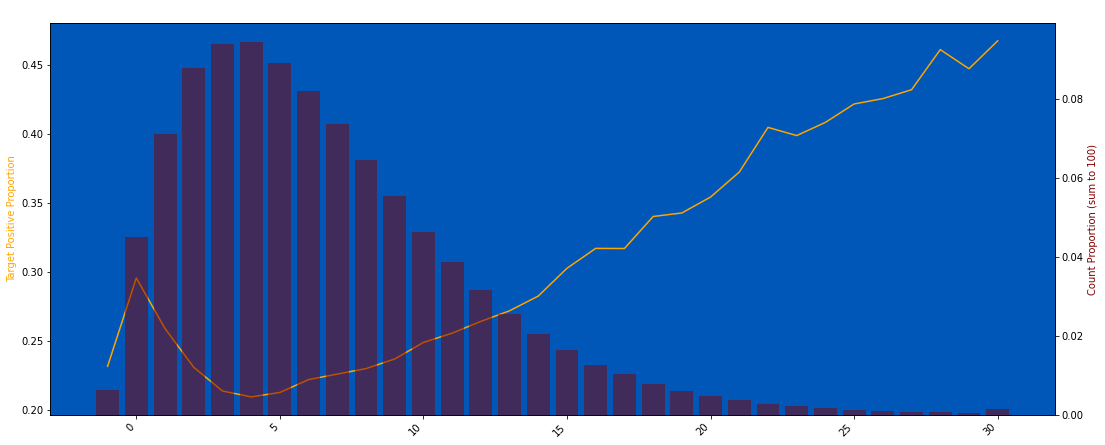

In [139]:
plot_target_check(train, "D_124", q=50, use_raw_bin=True, without_drop_tail=True)

In [140]:
# plot_train_test_distribution(df_list, "D_124", nunique_thr=500, without_drop_tail=True)

### D_125 @Binary, Increasing

In [141]:
# plot_target_check(train, "D_125", q=50, use_raw_bin=True)

In [142]:
for df in df_list:
    df["D_125"] = np.where(df["D_125"] == 0, np.nan, df["D_125"])

In [143]:
print_percentile(df_list, "D_125", 99.99)

99.99th percentile:
train : 5.0
public test : 4.0
private test : 5.0


In [144]:
for df in df_list:
    df = clip_col(df, "D_125", top_value=1, add_new_col=False)
    df["D_125"] = df["D_125"].fillna(0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


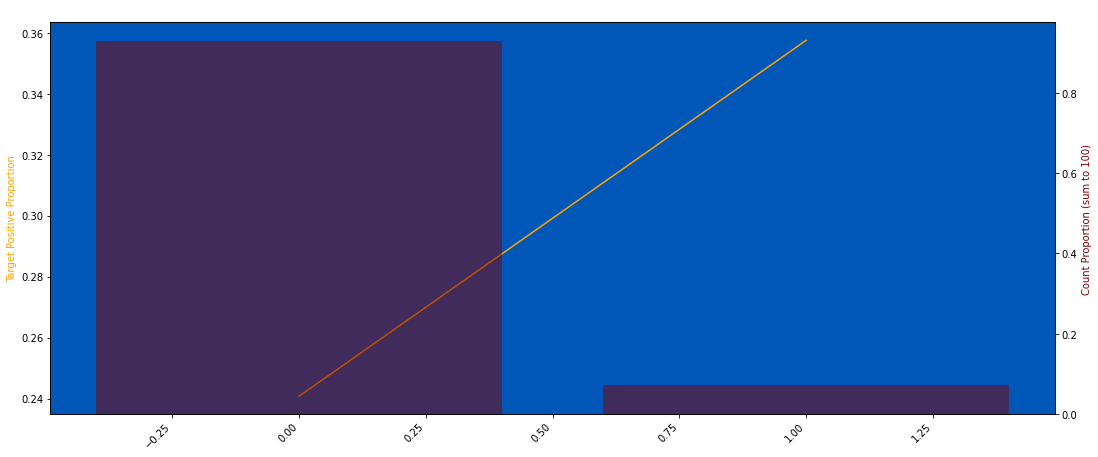

In [145]:
plot_target_check(train, "D_125", q=50, use_raw_bin=True, without_drop_tail=True)

In [146]:
# plot_train_test_distribution(df_list, "D_125", nunique_thr=500, without_drop_tail=True)

### D_126 @Category

In [147]:
for df in df_list:
    df["D_126"] += 1
    df["D_126"] = df["D_126"].replace(0, 3).fillna(0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


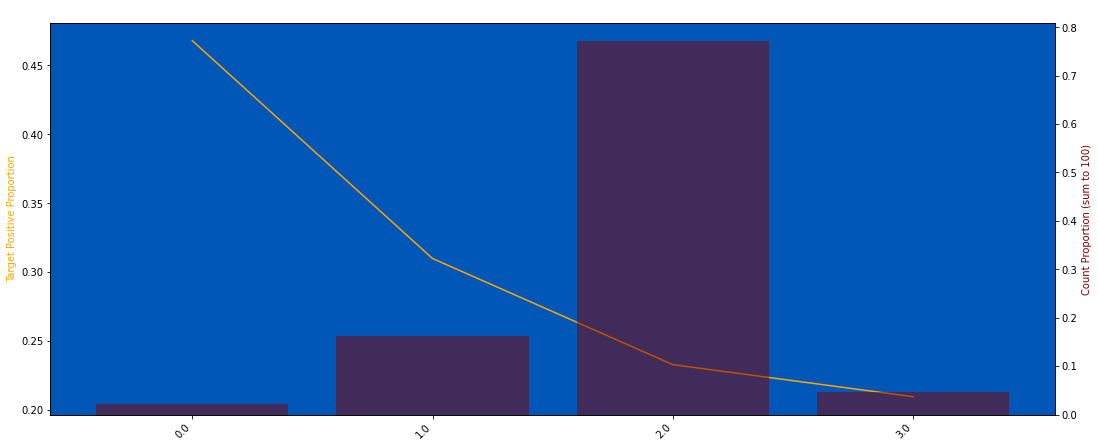

In [148]:
plot_target_check(train, "D_126", q=50, use_raw_bin=True, strfy_x=True, without_drop_tail=True)

In [149]:
# plot_train_test_distribution(df_list, "D_126", nunique_thr=1000, without_drop_tail=True)

### D_128 (Done Binary)

In [150]:
# plot_target_check(train, "D_128", q=50, use_raw_bin=True)

In [151]:
%%time
df_list = round_dfs(df_list, col="D_128", decimals=2, add_new_col=False)

CPU times: user 840 ms, sys: 2.62 s, total: 3.46 s
Wall time: 4.45 s


In [152]:
for df in df_list:
    df["D_128"] = df["D_128"].round(1)

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1


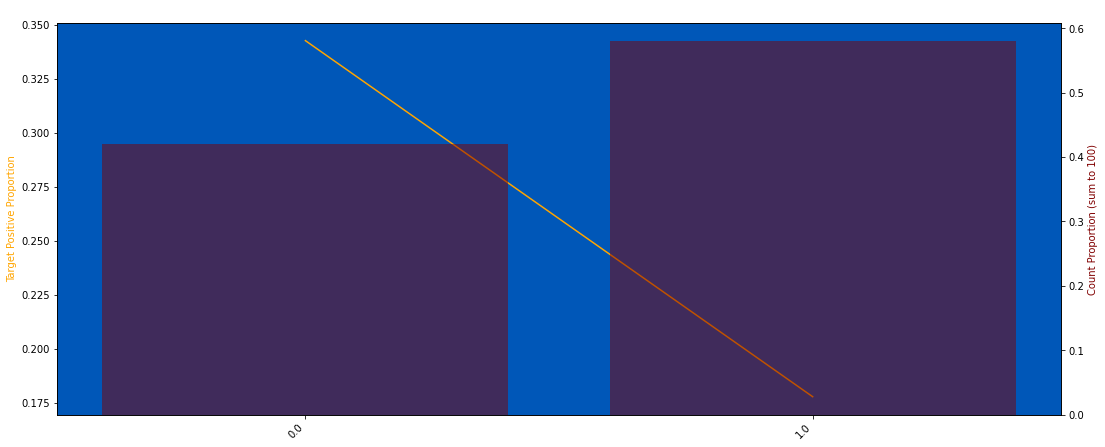

In [153]:
plot_target_check(train, "D_128", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [154]:
# plot_train_test_distribution(df_list, "D_128", nunique_thr=500)

### D_129 @Binary, Decreasing

In [155]:
# plot_target_check(train, "D_129", q=50, use_raw_bin=True)

In [156]:
for df in df_list:
    df["D_129"] = df["D_129"].round(1)

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1


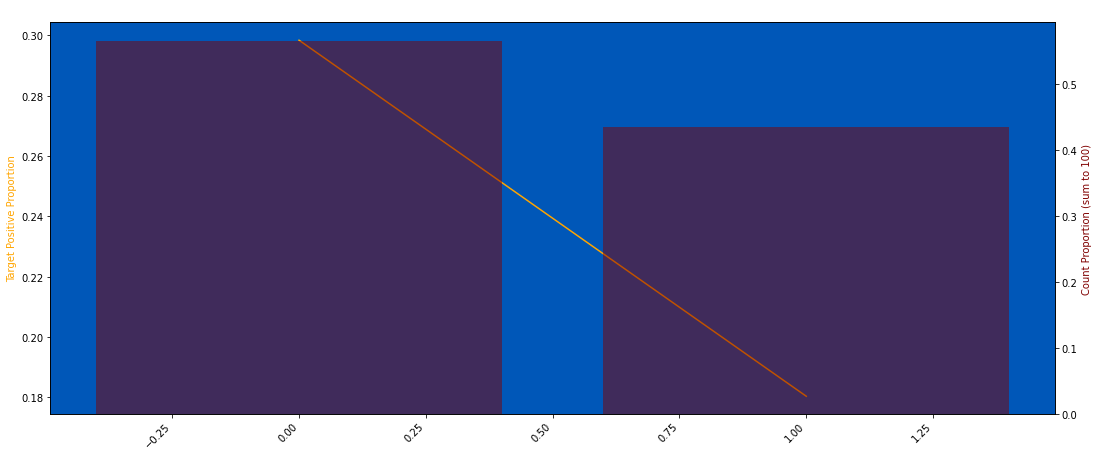

In [157]:
plot_target_check(train, "D_129", q=50, use_raw_bin=True, without_drop_tail=True)

In [158]:
# plot_train_test_distribution(df_list, "D_129", nunique_thr=500)

### D_130 @Binary, Increasing

In [159]:
# plot_target_check(train, "D_130", q=50, use_raw_bin=True)

In [160]:
for df in df_list:
    df["D_130"] = np.where(df["D_130"] > 1, 1, df["D_130"])

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1


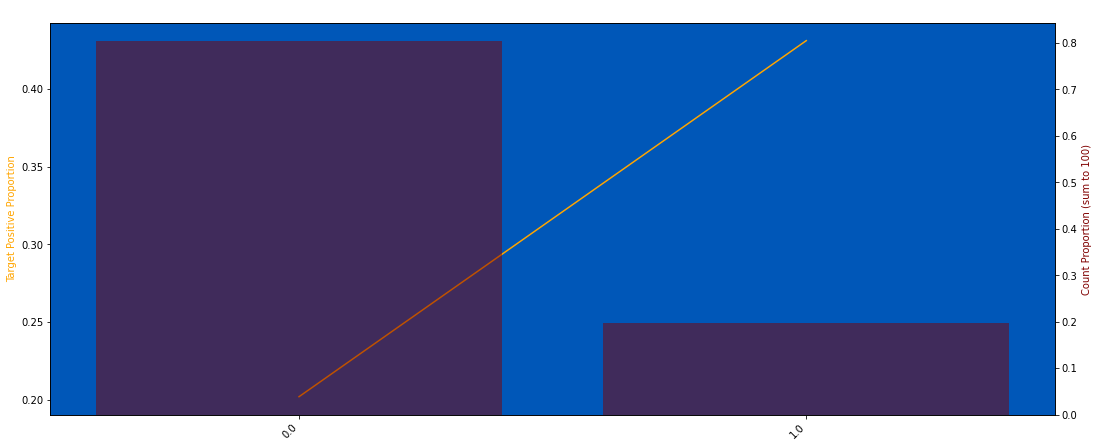

In [161]:
plot_target_check(train, "D_130", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [162]:
# plot_train_test_distribution(df_list, "D_130", nunique_thr=500, without_drop_tail=True)

### D_131 @Continuous, Decreasing

In [163]:
# plot_target_check(train, "D_131", q=50, use_raw_bin=True)

In [164]:
%%time
for df in df_list:
    df["D_131"] = df["D_131"].replace(0, np.nan)

CPU times: user 289 ms, sys: 245 ms, total: 534 ms
Wall time: 533 ms


In [165]:
describe_all(df_list, "D_131")

,train,public test,private test
count,"542,583.0000","672,363.0000","682,761.0000"
mean,0.9845,0.9836,0.9838
std,0.0201,0.0185,0.0179
min,0.9600,0.9600,0.9600
25%,0.9700,0.9700,0.9700
50%,0.9800,0.9800,0.9800
75%,0.9900,0.9900,0.9900
max,1.4900,1.4500,1.5400
null_proportion,0.9019,0.8824,0.8790


In [166]:
print_percentile(df_list, "D_131", 99)

99th percentile:
train : 1.04
public test : 1.04
private test : 1.03


In [167]:
for df in df_list:
    df = clip_col(df, "D_131", top_value=1.04, add_new_col=False)
    df = clip_col(df, "D_131", btm_value=0.97, add_new_col=False)

4988868 null count, 0.902 null proportion
0.2164 of the targets have label = 1


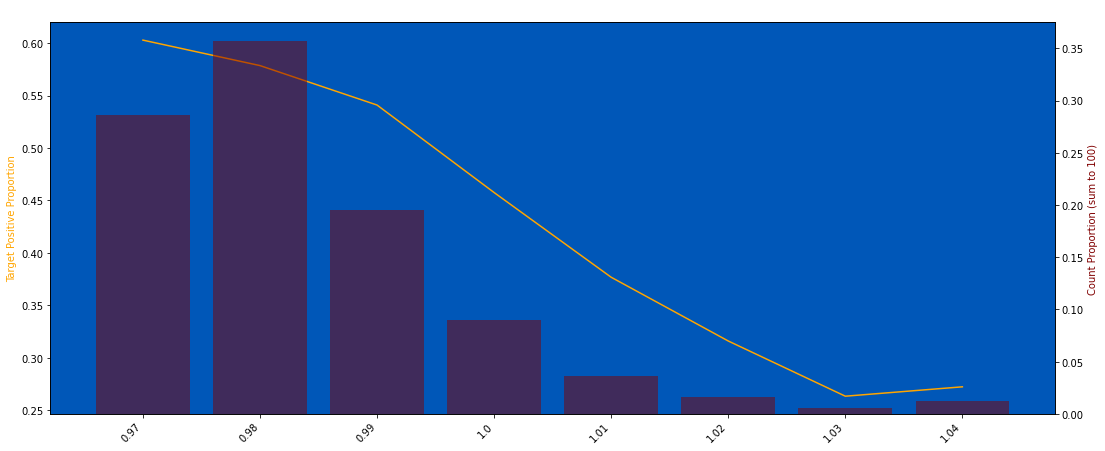

In [168]:
plot_target_check(train, "D_131", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [169]:
# plot_train_test_distribution(df_list, "D_131", nunique_thr=500, without_drop_tail=True)

### D_132 @Continuous, Decreasing

In [170]:
# plot_target_check(train, "D_132", q=50, use_raw_bin=True)

In [171]:
describe_all(df_list, "D_132")

,train,public test,private test
count,"542,577.0000","672,213.0000","682,631.0000"
mean,0.2052,0.1993,0.2021
std,0.2476,0.2327,0.2248
min,-0.0200,-0.0200,-0.0200
25%,0.0700,0.0700,0.0700
50%,0.1600,0.1400,0.1500
75%,0.2700,0.2700,0.2700
max,6.0300,5.5600,6.6800
null_proportion,0.9019,0.8825,0.8791


In [172]:
print_percentile(df_list, "D_132", 98.5)

98.5th percentile:
train : 0.79
public test : 0.72
private test : 0.72


In [173]:
for df in df_list:
    df = clip_col(df, "D_132", top_value=1, add_new_col=False)

4988874 null count, 0.902 null proportion
0.2164 of the targets have label = 1


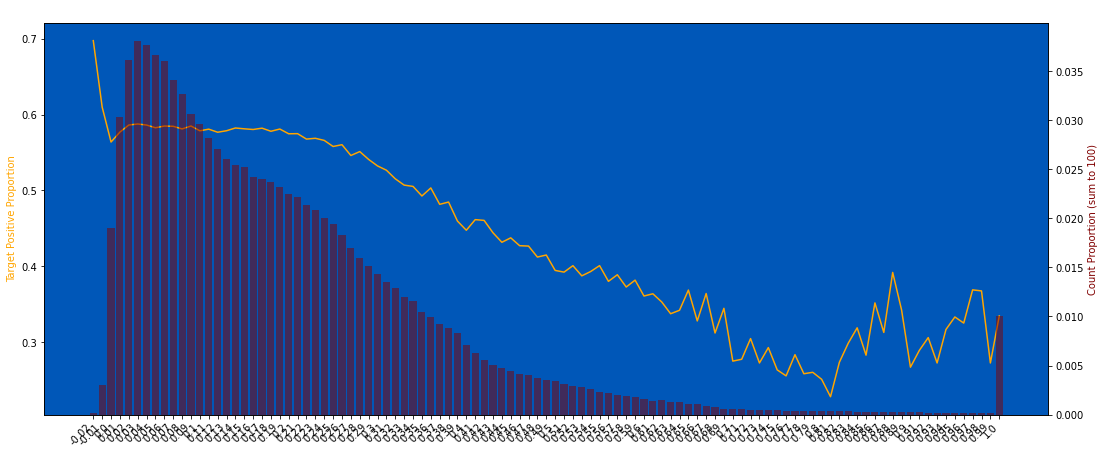

In [174]:
plot_target_check(train, "D_132", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [175]:
# plot_train_test_distribution(df_list, "D_132", nunique_thr=5000, without_drop_tail=True)

### D_133 @Continuous, Decreasing

In [176]:
# plot_target_check(train, "D_133", q=50, use_raw_bin=True)

In [177]:
for df in df_list:
    df["D_133"] = df["D_133"].replace(0, np.nan)

5086285 null count, 0.920 null proportion
0.2239 of the targets have label = 1


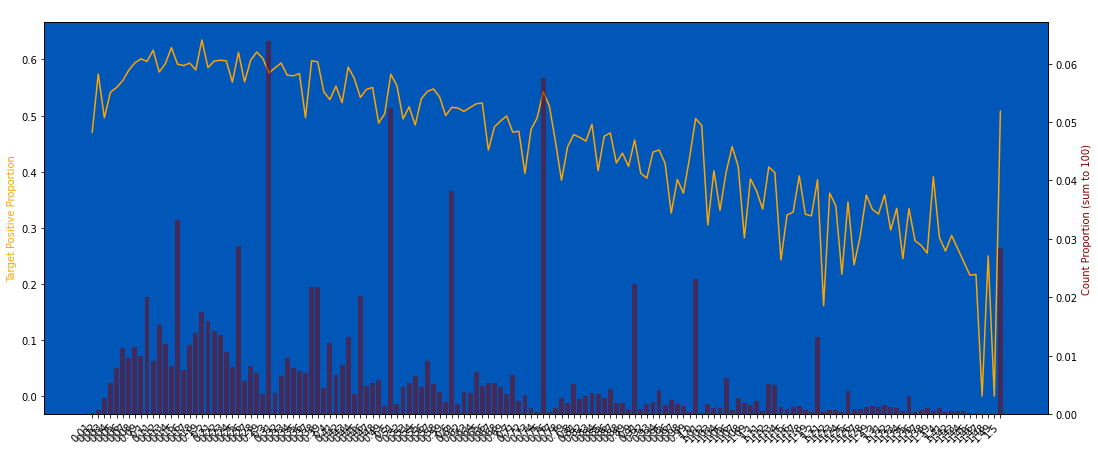

In [178]:
plot_target_check(train, "D_133", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [179]:
# plot_train_test_distribution(df_list, "D_133", nunique_thr=5000, without_drop_tail=True)

### D_134 @Continuous, N

In [180]:
# plot_target_check(train, "D_134", q=50, use_raw_bin=True)

5336752 null count, 0.965 null proportion
0.2360 of the targets have label = 1


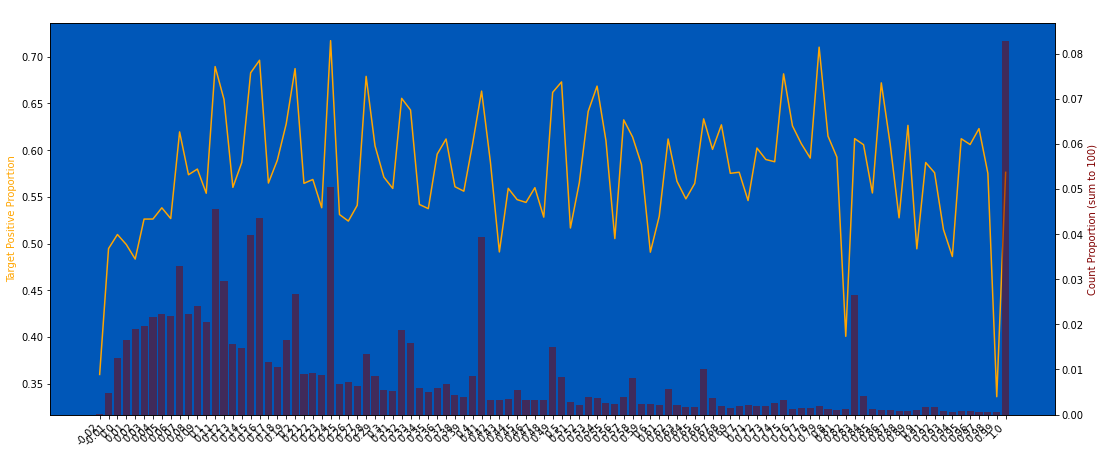

In [181]:
plot_target_check(train, "D_134", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [182]:
# plot_train_test_distribution(df_list, "D_134", nunique_thr=5000, without_drop_tail=True)

### D_136 @Integer, Increasing

In [183]:
# plot_target_check(train, "D_136", q=50, use_raw_bin=True)

In [184]:
for df in df_list:
    df["D_136"] = (df["D_136"] * 4).round(0)

In [185]:
describe_all(df_list, "D_136")

,train,public test,private test
count,"194,699.0000","193,382.0000","168,663.0000"
mean,0.9511,0.9630,0.9320
std,0.8405,0.8299,0.8007
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,1.0000,1.0000,1.0000
75%,1.0000,1.0000,1.0000
max,7.0000,7.0000,7.0000
null_proportion,0.9648,0.9662,0.9701


In [186]:
print_percentile(df_list, "D_136", 99.9)

99.9th percentile:
train : 6.0
public test : 6.0
private test : 6.0


In [187]:
for df in df_list:
    df = clip_col(df, "D_136", top_value=6, add_new_col=False)

5336752 null count, 0.965 null proportion
0.2360 of the targets have label = 1


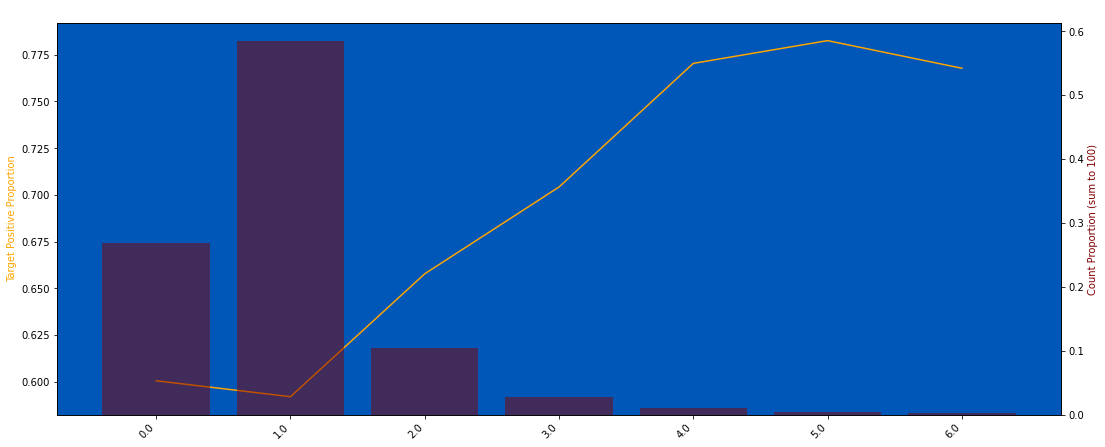

In [188]:
plot_target_check(train, "D_136", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [189]:
# plot_train_test_distribution(df_list, "D_136", nunique_thr=5000, without_drop_tail=True)

### D_141 @Continuous, Increasing

In [190]:
# plot_target_check(train, "D_141", q=50, use_raw_bin=True)

In [191]:
for df in df_list:
    df["D_141"] = df["D_141"].replace(0, np.nan)

In [192]:
describe_all(df_list, "D_141")

,train,public test,private test
count,"944,418.0000","998,943.0000","968,218.0000"
mean,0.9172,0.9190,0.9203
std,0.0498,0.0517,0.0524
min,0.8500,0.8500,0.8500
25%,0.8700,0.8700,0.8700
50%,0.9100,0.9100,0.9100
75%,0.9600,0.9600,0.9600
max,1.3300,1.3200,1.2800
null_proportion,0.8293,0.8253,0.8285


In [193]:
print_percentile(df_list, "D_141", 99.99)

99.99th percentile:
train : 1.21
public test : 1.2410579999990297
private test : 1.23


In [194]:
for df in df_list:
    df = clip_col(df, "D_141", top_value=1.16, add_new_col=False)

4587033 null count, 0.829 null proportion
0.2248 of the targets have label = 1


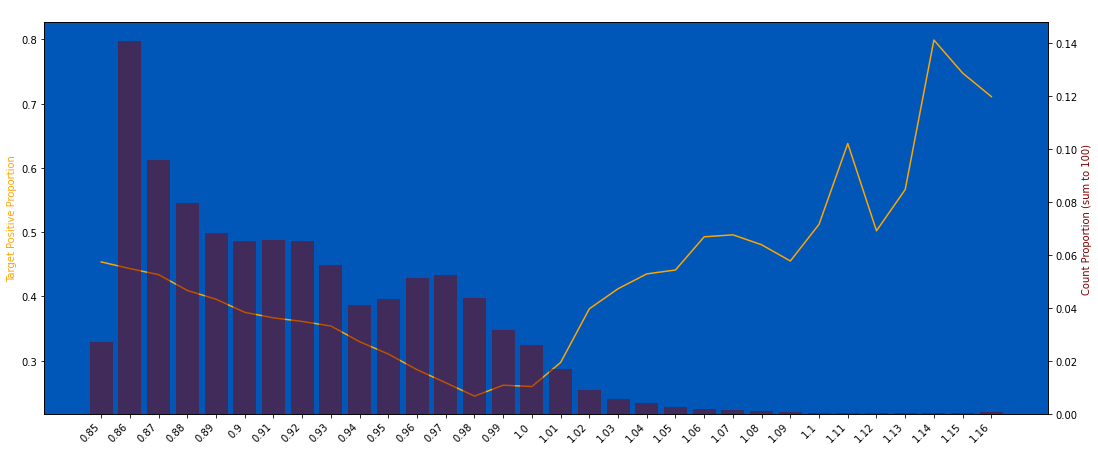

In [195]:
plot_target_check(train, "D_141", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [196]:
# plot_train_test_distribution(df_list, "D_141", nunique_thr=500, without_drop_tail=True)

### D_142 @Continuous, Increasing

In [197]:
# plot_target_check(train, "D_142", q=50, use_raw_bin=True)

In [198]:
describe_all(df_list, "D_142")

,train,public test,private test
count,"944,408.0000","998,742.0000","968,053.0000"
mean,0.3858,0.3985,0.4054
std,0.2362,0.2465,0.2503
min,-0.0200,-0.0200,-0.0200
25%,0.1900,0.1900,0.2000
50%,0.3800,0.3900,0.3900
75%,0.5500,0.5800,0.6000
max,2.2200,2.2800,2.1100
null_proportion,0.8293,0.8254,0.8285


In [199]:
print_percentile(df_list, "D_142", 99.9)

99.9th percentile:
train : 1.42
public test : 1.45
private test : 1.45


In [200]:
for df in df_list:
    df = clip_col(df, "D_142", top_value=1.5, add_new_col=False)
    df["D_142"] = df["D_142"].replace(-0.02, np.nan)

4587099 null count, 0.829 null proportion
0.2248 of the targets have label = 1


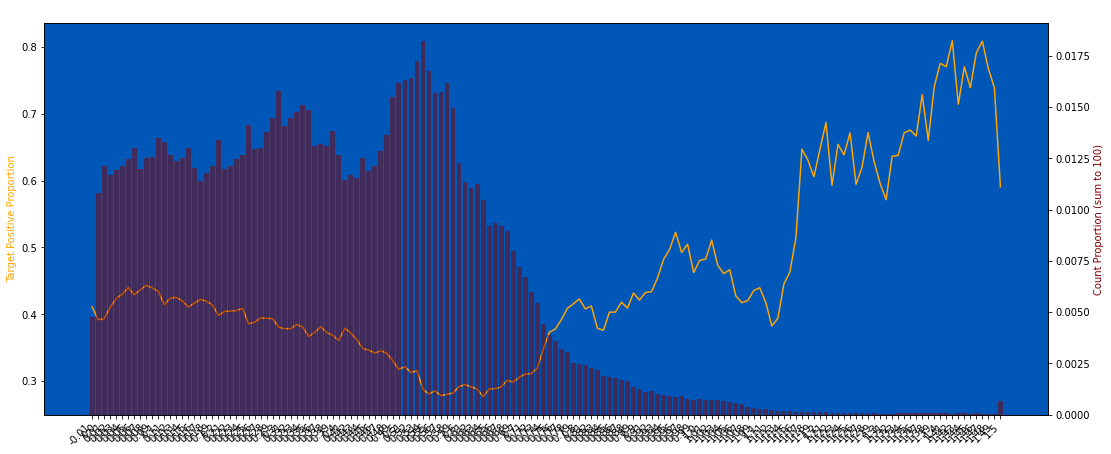

In [201]:
plot_target_check(train, "D_142", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [202]:
# plot_train_test_distribution(df_list, "D_142", nunique_thr=500)

### D_144 @Continuous, -

In [203]:
# plot_target_check(train, "D_144", q=50, use_raw_bin=True)

In [204]:
%%time
df_list = round_dfs(df_list, col="D_144", decimals=2, add_new_col=False)

CPU times: user 818 ms, sys: 2.39 s, total: 3.21 s
Wall time: 4.29 s


In [205]:
for df in df_list:
    df["D_144"] = df["D_144"].replace(0, np.nan)

5025503 null count, 0.909 null proportion
0.2481 of the targets have label = 1


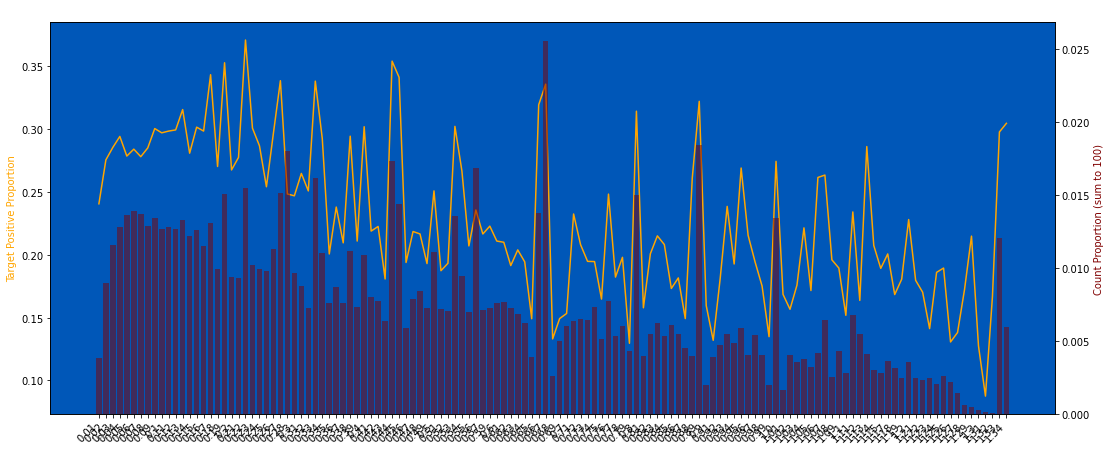

In [206]:
plot_target_check(train, "D_144", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [207]:
# plot_train_test_distribution(df_list, "D_144", nunique_thr=500)

### D_145 @Integer, Increasing

In [208]:
# plot_target_check(train, "D_145", q=50, use_raw_bin=True, nunique_thr=1000)

In [209]:
for df in df_list:
    df["D_145"] = (df["D_145"] / 0.091).round(0)

In [210]:
describe_all(df_list, "D_145")

,train,public test,private test
count,"5,429,903.0000","5,666,462.0000","5,599,600.0000"
mean,0.6307,0.6524,0.6407
std,2.1282,2.1743,2.1672
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,53.0000,46.0000,60.0000
null_proportion,0.0184,0.0093,0.0079


In [211]:
print_percentile(df_list, "D_145", 99.9)

99.9th percentile:
train : 21.0
public test : 20.0
private test : 21.0


In [212]:
for df in df_list:
    df = clip_col(df, "D_145", top_value=20, add_new_col=False)

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1


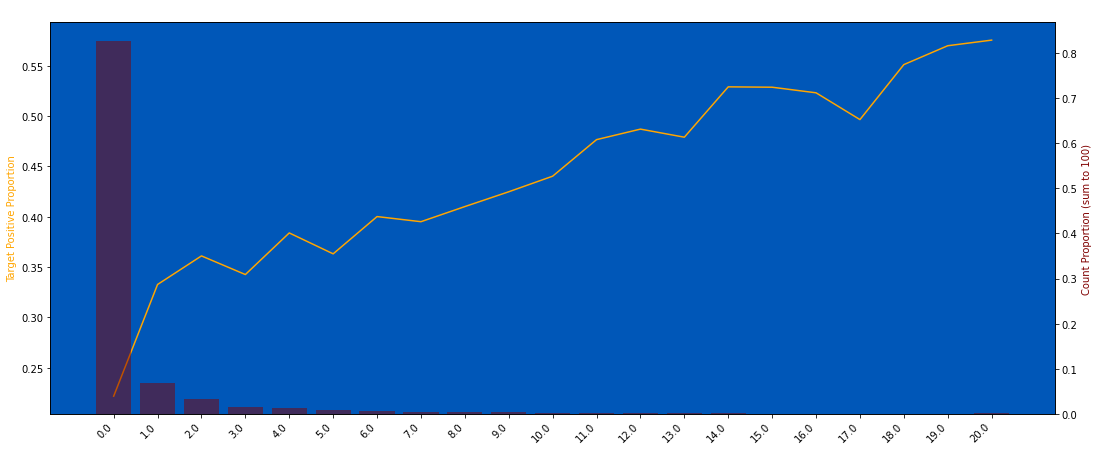

In [213]:
plot_target_check(train, "D_145", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [214]:
# plot_train_test_distribution(df_list, "D_145", nunique_thr=500, without_drop_tail=True)

### Column checking

In [215]:
all_columns = get_cols(df_list[0], ["D_"])
print(all_columns)

['D_102', 'D_104', 'D_105', 'D_106', 'D_107', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_136', 'D_141', 'D_142', 'D_144', 'D_145', 'D_183', 'D_1314', 'D_1343']


In [216]:
%%time
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 99].index.tolist()

CPU times: user 1.81 s, sys: 474 ms, total: 2.28 s
Wall time: 2.28 s


In [217]:
print(less_unique_d_cols)

['D_104', 'D_106', 'D_107', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_114', 'D_117', 'D_120', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_130', 'D_131', 'D_136', 'D_141', 'D_145', 'D_183', 'D_1314', 'D_1343']


In [218]:
%%time
for col in less_unique_d_cols:
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

D_106 fulfill criteria to convert to integer
D_107 fulfill criteria to convert to integer
D_109 fulfill criteria to convert to integer
D_110 fulfill criteria to convert to integer
D_111 fulfill criteria to convert to integer
D_112 fulfill criteria to convert to integer
D_113 fulfill criteria to convert to integer
D_114 fulfill criteria to convert to integer
D_117 fulfill criteria to convert to integer
D_120 fulfill criteria to convert to integer
D_122 fulfill criteria to convert to integer
D_123 fulfill criteria to convert to integer
D_124 fulfill criteria to convert to integer
D_125 fulfill criteria to convert to integer
D_126 fulfill criteria to convert to integer
D_128 fulfill criteria to convert to integer
D_129 fulfill criteria to convert to integer
D_130 fulfill criteria to convert to integer
D_136 fulfill criteria to convert to integer
D_145 fulfill criteria to convert to integer
D_183 fulfill criteria to convert to integer
D_1343 fulfill criteria to convert to integer
CPU times

In [229]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp']

In [230]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

CPU times: user 793 ms, sys: 172 ms, total: 965 ms
Wall time: 961 ms


In [231]:
%%time
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

D_1314 fulfill criteria to convert to float32
CPU times: user 52.9 ms, sys: 651 µs, total: 53.5 ms
Wall time: 51.6 ms


### Verify if all columns have been clipped

In [232]:
for col in tqdm(df_list[0].columns):
    if col in NON_FEATURE_COLUMNS:
        continue
    if not (df_list[0][col].min() == df_list[1][col].min() == df_list[2][col].min()):
        print(f"Min of column {col} is different: {df_list[0][col].min()}, {df_list[1][col].min()}, {df_list[2][col].min()}")
    
    if not (df_list[0][col].max() == df_list[1][col].max() == df_list[2][col].max()):
        print(f"Max of column {col} is different: {df_list[0][col].max()}, {df_list[1][col].max()}, {df_list[2][col].max()}")

100%|██████████| 41/41 [00:01<00:00, 26.56it/s]


In [233]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 8.21 s, sys: 1.07 s, total: 9.28 s
Wall time: 9.27 s


In [234]:
train.shape, test.shape

((5531451, 41), (11363762, 40))

In [235]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

(1.687092571, 3.284127362)

In [236]:
%%time
train.to_parquet(f"./train_parquet/train_delinquency_part2_.parquet")
test.to_parquet(f"./test_parquet/test_delinquency_part2_.parquet")

CPU times: user 14.6 s, sys: 811 ms, total: 15.4 s
Wall time: 14.7 s


In [237]:
END = time.time()

In [238]:
print(f"{END - START:.2f} seconds elapsed")

543.62 seconds elapsed
